-Added 2 layers to autoencoder
-changed img input

In [ ]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
from sklearn.neighbors import KernelDensity
import random
import shutil
import tensorflow as tf

import glob

In [ ]:
% matplotlib inline

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls   #check if mounted correctly

DATADIR = "/content/gdrive/My Drive/gpu_stress_encoder"
os.listdir('/content/gdrive/My Drive/gpu_stress_encoder')     #show directories in base directory

Mounted at /content/gdrive
gdrive	sample_data


['train', 'val']

In [ ]:
Classes = ["idle_gpu"]

In [ ]:
import random
for cl in Classes:
  img_path = os.path.join(DATADIR, cl)    # Merge DATADIR with class name
  print(img_path)
  images = glob.glob(img_path + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
  random.shuffle(images)                    # randomly shuffle list
  print("{}: {} Images". format(cl,len(images)))
  num_train = int(round(len(images)*0.7))     # Find what 70% of images is
  train, val = images[:num_train], images[num_train:]   # Assign 70% and 30% of images to training and validation datasets respectively. list starting at index 0 up to but not including num_train

  for t in train:
    if not os.path.exists(os.path.join(DATADIR, 'train', cl)):
      os.makedirs(os.path.join(DATADIR, 'train', cl))
    shutil.move(t, os.path.join(DATADIR, 'train', cl))      # Move images to train directory

  for v in val:
    if not os.path.exists(os.path.join(DATADIR, 'val', cl)):
      os.makedirs(os.path.join(DATADIR, 'val', cl))
    shutil.move(v, os.path.join(DATADIR, 'val', cl))        #Move images to val director

/content/gdrive/My Drive/gpu_stress_encoder/idle_gpu
idle_gpu: 1000 Images


In [ ]:
batch_size = 64
IMG_width = 160
IMG_height= 160

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/gpu_stress_encoder/train/idle_gpu_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/gpu_stress_encoder/val/idle_gpu_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'      #Use for Autoencoders because there is one class, its input and output
    )

anomaly_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
anomaly_generator = anomaly_datagen.flow_from_directory(
    '/content/gdrive/My Drive/gpu_stress_encoder/train/gpu_stress_autoencoder',
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )

images = glob.glob('/content/gdrive/My Drive/gpu_stress_encoder/train/idle_gpu_autoencoder/idle_gpu' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('train:idle_gpu_autoencoder',len(images)))

images = glob.glob('/content/gdrive/My Drive/gpu_stress_encoder/val/idle_gpu_autoencoder/idle_gpu' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('val:idle_gpu_autoencoder',len(images)))

images = glob.glob('/content/gdrive/My Drive/gpu_stress_encoder/train/gpu_stress_autoencoder/gpu_stress' + '/*.jpg')   # Take path name and include everything with .jpg. Return list of all images
print("{}: {} Images". format('test:gpu_stress_autoencoder',len(images)))


Found 700 images belonging to 1 classes.
Found 300 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
train:idle_gpu_autoencoder: 700 Images
val:idle_gpu_autoencoder: 300 Images
test:gpu_stress_autoencoder: 1000 Images


In [ ]:
# Define the convolutional autoencoder model 
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(IMG_height, IMG_width, 3)))
model.add(MaxPooling2D(pool_size=(2,2), padding='same')) # using pool_size (2,2) makes the layer 2x smaller in height and width

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(16,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))
#-------------------------

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 3)         219       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 3)         8

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) # Early stopping (stops training when validation doesn't improve for {patience} epochs).  min_delta=1 to abort if improvement is less than 1%. verbose displayes last epoch
model_filepath = 'models/gpu_stress_autoencoder.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min',  verbose=1) # Saves the best version of the model to disk (as measured on the validation data set)
model.fit(
        train_generator,        #add accuracy metric
        steps_per_epoch=int(np.ceil(train_generator.n / float(batch_size))),
        epochs=600,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(validation_generator.n / float(batch_size))),
        shuffle = True,
        callbacks=[es, save_best])

Epoch 1/600
11/11 [==============================] - 290s 26s/step - loss: 0.1313 - val_loss: 0.1176

Epoch 00001: val_loss improved from inf to 0.11762, saving model to models/gpu_stress_autoencoder.keras
Epoch 2/600
11/11 [==============================] - 3s 265ms/step - loss: 0.1004 - val_loss: 0.0484

Epoch 00002: val_loss improved from 0.11762 to 0.04839, saving model to models/gpu_stress_autoencoder.keras
Epoch 3/600
11/11 [==============================] - 3s 264ms/step - loss: 0.0468 - val_loss: 0.0446

Epoch 00003: val_loss improved from 0.04839 to 0.04458, saving model to models/gpu_stress_autoencoder.keras
Epoch 4/600
11/11 [==============================] - 3s 264ms/step - loss: 0.0411 - val_loss: 0.0328

Epoch 00004: val_loss improved from 0.04458 to 0.03281, saving model to models/gpu_stress_autoencoder.keras
Epoch 5/600
11/11 [==============================] - 3s 264ms/step - loss: 0.0307 - val_loss: 0.0258

Epoch 00005: val_loss improved from 0.03281 to 0.02581, saving

In [ ]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model('./models/gpu_stress_autoencoder.keras')

In [ ]:
model_filepath      #check model name

'models/gpu_stress_autoencoder.keras'

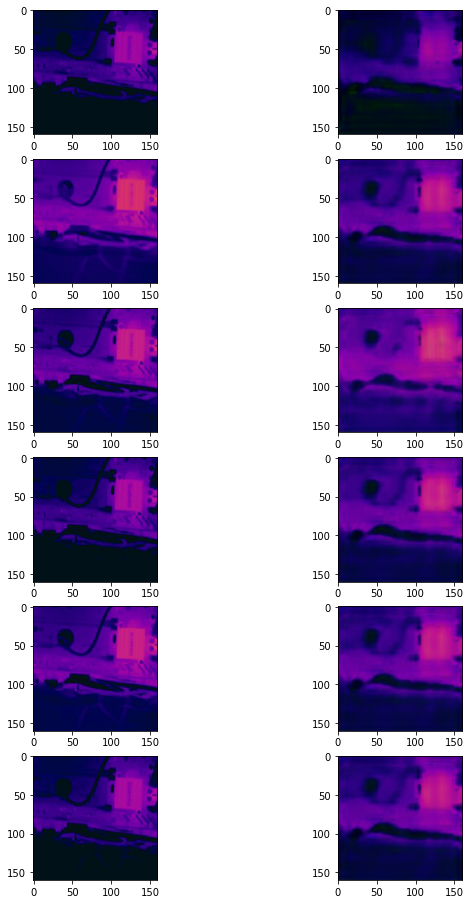

In [ ]:
# Test the model by viewing a sample of original and reconstructed images of training dataset 
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = round(len(train_generator)/2)    #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=no_of_samples, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

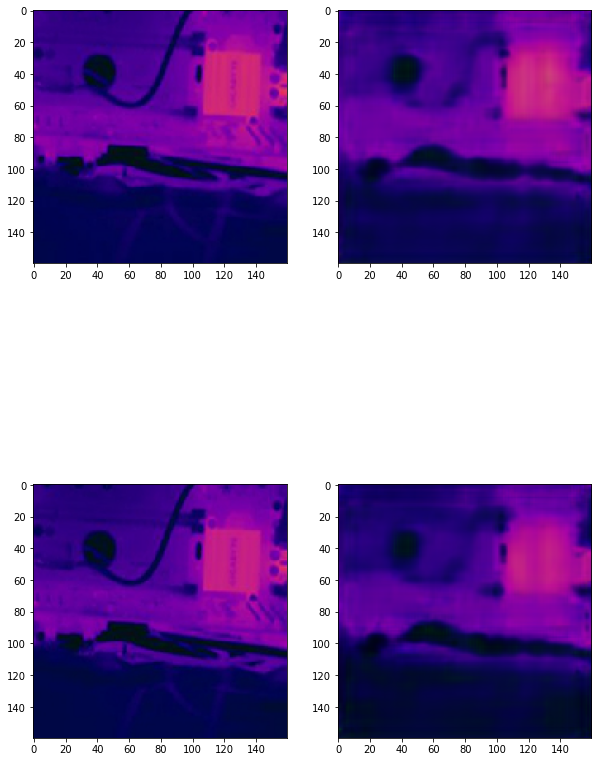

In [ ]:
# Test the model by viewing a sample of original and reconstructed images of validation dataset
data_list = []
batch_index = 0
while batch_index <= validation_generator.batch_index:
    data = validation_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = round(len(validation_generator)/2)        #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=no_of_samples, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

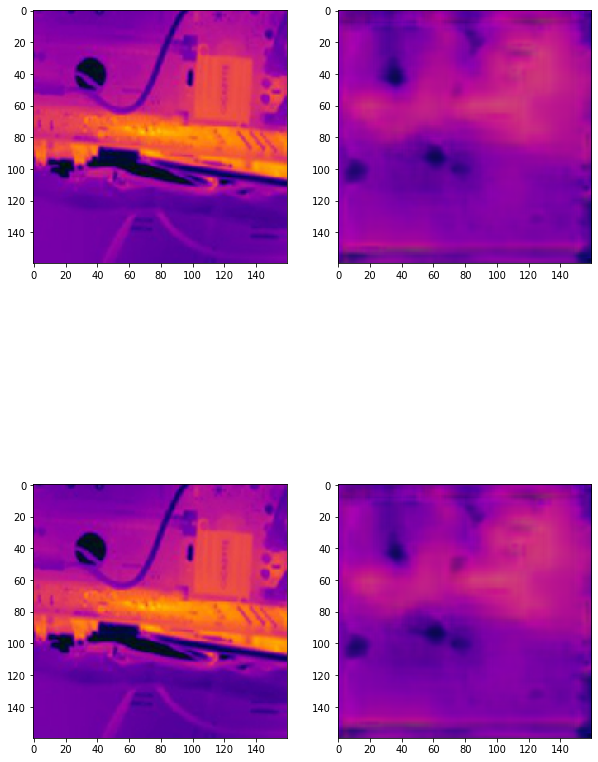

In [ ]:
# Test the model by viewing a sample of original and reconstructed images of anomaly dataset
data_list = []
batch_index = 0
while batch_index <= anomaly_generator.batch_index:
    data = anomaly_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 4     #3 because thats how many objects in train_generator iterator
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 16))   #axs is the location of the fig

axs = axs.flatten()
imgs = []
for i in range(no_of_samples):    
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])


for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [ ]:

# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate(validation_generator)}, error on anomaly set:{model.evaluate(anomaly_generator)}")

16/16 [==============================] - 3s 175ms/step - loss: 0.0349
Error on validation set:0.002265126211568713, error on anomaly set:0.03485441580414772


In [ ]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 96x96x3 and compresses it down to a 3x3x3 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(IMG_height, IMG_width, 3), weights=model.layers[0].get_weights(), name='encoder_conv_1') )    #get weights from original model
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_1'))
encoder_replica.add(Conv2D(8,(3, 3),activation='relu',  padding='same', weights=model.layers[2].get_weights(), name='encoder_conv_2'))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_2'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[4].get_weights(), name='encoder_conv_3'))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_3'))
encoder_replica.add(Conv2D(3,(3, 3),activation='relu',  padding='same', weights=model.layers[6].get_weights(), name='encoder_conv_4'))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same', name='encoder_maxpool_4'))
encoder_replica.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_conv_1 (Conv2D)      (None, 160, 160, 16)      448       
_________________________________________________________________
encoder_maxpool_1 (MaxPoolin (None, 80, 80, 16)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 80, 80, 8)         1160      
_________________________________________________________________
encoder_maxpool_2 (MaxPoolin (None, 40, 40, 8)         0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 40, 40, 3)         219       
_________________________________________________________________
encoder_maxpool_3 (MaxPoolin (None, 20, 20, 3)         0         
_________________________________________________________________
encoder_conv_4 (Conv2D)      (None, 20, 20, 3)         8

In [ ]:
encoder_replica.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
encoder_replica.save("gpu_stress_encoder")

INFO:tensorflow:Assets written to: gpu_stress_encoder/assets


In [ ]:
#zip a folder under /content/Folder_To_Zip
!zip -r /content/file.zip  /content/gpu_stress_encoder

  adding: content/gpu_stress_encoder/ (stored 0%)
  adding: content/gpu_stress_encoder/variables/ (stored 0%)
  adding: content/gpu_stress_encoder/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: content/gpu_stress_encoder/variables/variables.index (deflated 54%)
  adding: content/gpu_stress_encoder/assets/ (stored 0%)
  adding: content/gpu_stress_encoder/saved_model.pb (deflated 90%)


In [ ]:
model.save("gpu_stress_autoencoder")

INFO:tensorflow:Assets written to: gpu_stress_autoencoder/assets


In [ ]:
#zip a folder under /content/Folder_To_Zip
!zip -r /content/file.zip  /content/gpu_stress_autoencoder

  adding: content/gpu_stress_autoencoder/ (stored 0%)
  adding: content/gpu_stress_autoencoder/variables/ (stored 0%)
  adding: content/gpu_stress_autoencoder/variables/variables.data-00000-of-00001 (deflated 23%)
  adding: content/gpu_stress_autoencoder/variables/variables.index (deflated 73%)
  adding: content/gpu_stress_autoencoder/assets/ (stored 0%)
  adding: content/gpu_stress_autoencoder/saved_model.pb (deflated 91%)


In [ ]:
# get dimensions of the last layer of 'encoder_replica' model
layer=encoder_replica.get_layer('encoder_maxpool_4')
layer_list=layer.get_output_at(0).get_shape().as_list()
dim= layer_list[1]*layer_list[2]*layer_list[3]



print("Last layer has dimensions: {}*{}*{}". format(layer_list[1],layer_list[2],layer_list[3]))
print("Product of layer dimensions: {}". format(dim))


Last layer has dimensions: 10*10*3
Product of layer dimensions: 300


In [ ]:
# Creating encoded (compressed versions of the training, validation and anomalous images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder

encoded_images = encoder_replica.predict(train_generator)
encoded_images_flat = [np.reshape(img, (dim)) for img in encoded_images]      #to get the second argument multiply the dimensions in encoded_images: 12*12*3=432. Do this to flatten image

validation_encoded = encoder_replica.predict(validation_generator)
val_enc_flat = [np.reshape(img, (dim)) for img in validation_encoded]

anom_encoded = encoder_replica.predict(anomaly_generator)
anom_enc_flat = [np.reshape(img, (dim)) for img in anom_encoded]

In [ ]:
np.savetxt("gpu_encoded_images_flat.csv", encoded_images_flat, delimiter=",")
np.savetxt("gpu_val_enc_flat.csv", val_enc_flat, delimiter=",")

# my_data = np.genfromtxt('foo.csv', delimiter=',')

202.83905823248963
[204.39322681 204.32319605 204.61695357 203.15638483 203.34261106
 202.74570224 204.79048064 204.00472132 204.47234993 203.78019742
 201.46660921 203.6890362  203.17176815 204.106659   202.27492065
 204.68528392 202.29493145 202.44793151 202.40101428 201.64252323
 202.42657097 204.63134293 204.47098352 202.23497169 204.03760134
 204.76028211 204.79492877 203.04264651 202.83265825 202.52516771
 203.64145077 203.1198168  204.83062775 204.81276713 201.73311715
 202.67984733 203.24813506 201.49482961 202.38968787 201.62295999
 203.42770565 204.4121133  202.87112257 203.55454535 203.82284495
 202.06644275 202.79872177 204.46260809 204.78645986 202.77344528
 202.79057912 202.72504178 202.5279476  202.54386118 204.34590281
 202.96440502 201.91483543 201.69122887 204.84599257 204.07772986
 204.69513387 203.29921377 202.12537276 202.71486041 203.04922122
 204.30189189 202.97937898 202.58970913 203.12760385 204.06934404
 204.70528224 204.69158046 202.83099044 203.06988536 204.

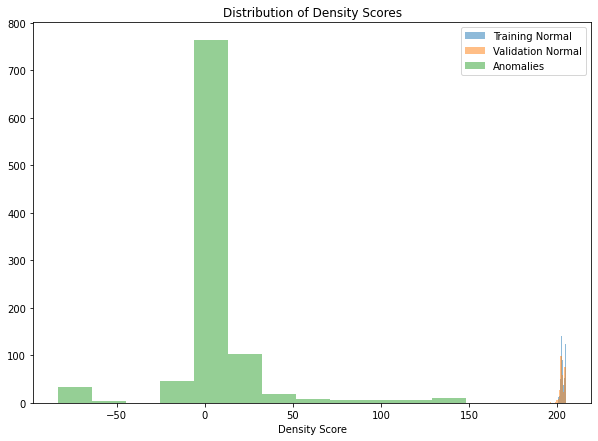

In [ ]:

# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)        # kernel density is a tool used to make discrete values smooth. bandwidth is how smooth it is. kernel is the function used. check https://mathisonian.github.io/kde/
training_density_scores = kde.score_samples(encoded_images_flat) 
print(np.median(training_density_scores))
print(training_density_scores)

validation_density_scores = kde.score_samples(val_enc_flat)
print(np.median(validation_density_scores))
print(validation_density_scores)

anomaly_density_scores = kde.score_samples(anom_enc_flat)
print(np.median(anomaly_density_scores))
print(anomaly_density_scores)



# Plotting the density distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, 12, alpha=0.5, label='Training Normal')
plt.hist(validation_density_scores, 12, alpha=0.5, label='Validation Normal')
plt.hist(anomaly_density_scores, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()

In [ ]:
# sorted_validation_density_scores=np.sort(validation_density_scores)
# print(sorted_validation_density_scores)

min_quantile = np.quantile(validation_density_scores, 0.01)   #obtain 0.01 smallest value on validatation density score
max_quantile = np.quantile(validation_density_scores, 0.99)   #obtain 0.99 biggest value on validatation density score

min_quantile_threshold=min_quantile - 10          #change 10 to a number based on tolerance level
max_quantile_threshold= max_quantile + 10         #change 10 to a number based on tolerance level

In [ ]:
# Create a function for classifying images in bulk (for testing purposes)
def get_mse(original, reconstruction):
    # Returns the mean square error for each image in the array
    return np.mean((original - reconstruction)**2, axis=(1,2,3)) 

def evaluate_model(test_file):
    # density_threshold = 175 # This threshold was chosen based on looking at the distribution of the density scores of the normal class (validation set)
    reconstruction_error_threshold = 0.020 # This threshold was chosen based on looking at the distribution of reconstruction errors of the normal class
    batch_size  = 0
    for (dirpath, dirnames, filenames) in os.walk(test_file):
        batch_size += len([file for file in filenames if file.endswith(".jpg")]) # Batchsize now is total images in folder
    
    test_img_generator = train_datagen.flow_from_directory(
    test_file,
    target_size=(IMG_height, IMG_width),
    batch_size=batch_size,
    class_mode='input'
    )
    
    images = test_img_generator.next()[0]   #load test images to variable images
    reconstructions = model.predict(images) #get reconstructed images
    MSEs = get_mse(images, reconstructions) #get mse
    reconstruction_anomalies = MSEs > reconstruction_error_threshold
    print(f'Reconstruction anomalies = {sum(reconstruction_anomalies)}')
    
    encoded_images = encoder_replica.predict(test_img_generator)
    encoded_images_flat = np.array([np.reshape(img, (dim)) for img in encoded_images])        #change argument (dim) to last layer dimensions product
    density_scores = kde.score_samples(encoded_images_flat)

    density_anomalies_min= density_scores < min_quantile_threshold      # check if desnity score is samller than threshold
    density_anomalies_max= density_scores > max_quantile_threshold      # check if desnity score is bigger than threshold
    density_anomalies = density_anomalies_min != density_anomalies_max    # get the resultant. example: density_anomalies_min= True,  density_anomalies_min= False ==> density_anomalies= True


    combined_anomalies = np.maximum(reconstruction_anomalies, density_anomalies)
    print(f'Combined anomalies = {sum(combined_anomalies)}')
    overall_detection_rate = sum(combined_anomalies) / len(combined_anomalies)
    print(f'Overall detection rate = {overall_detection_rate}')
    return  MSEs

In [ ]:
# Check what proportion of normal images get classified as anomalous
MSE_normal=evaluate_model('/content/gdrive/My Drive/gpu_stress_encoder/train/idle_gpu_autoencoder')

Found 700 images belonging to 1 classes.
Reconstruction anomalies = 0
Combined anomalies = 0
Overall detection rate = 0.0


In [ ]:
# Check what proportion of validation images get classified as anomalous
MSE_val=evaluate_model('/content/gdrive/My Drive/gpu_stress_encoder/val/idle_gpu_autoencoder')

Found 300 images belonging to 1 classes.
Reconstruction anomalies = 0
Combined anomalies = 0
Overall detection rate = 0.0


In [ ]:
# Check what proportion of anomaly images (a set which was unseen in training) get classified as anomalous
MSE_anom=evaluate_model('/content/gdrive/My Drive/gpu_stress_encoder/train/gpu_stress_autoencoder')

Found 1000 images belonging to 1 classes.
Reconstruction anomalies = 997
Combined anomalies = 1000
Overall detection rate = 1.0


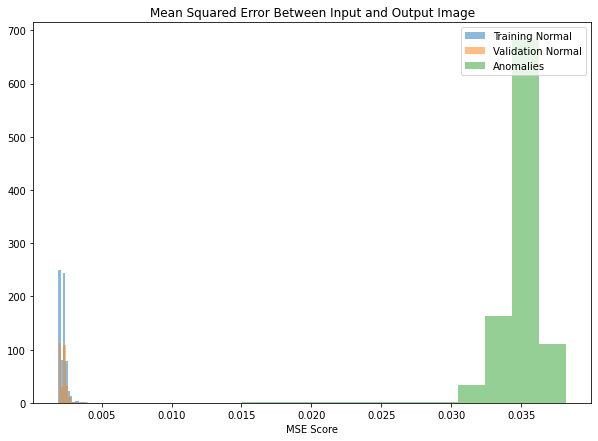

In [ ]:
plt.figure(figsize = (10,7))
plt.title('Mean Squared Error Between Input and Output Image')
plt.hist(MSE_normal, 12, alpha=0.5, label='Training Normal')
plt.hist(MSE_val, 12, alpha=0.5, label='Validation Normal')
plt.hist(MSE_anom, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('MSE Score')

plt.show()

In [ ]:
# This function can be used for ingference when the system is deployed it checks one image at a time
def check_anomaly(img_path):
    # density_threshold = 0 
    reconstruction_error_threshold = 0.020
    img  = Image.open(img_path)
    img = np.array(img.resize((IMG_height, IMG_width), Image.ANTIALIAS))
    img = img / 255
    img = tf.expand_dims(img, 0)

    encoded_img = encoder_replica.predict(img) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (dim)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
    print(f'density: {density}')
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)
    print(f'reconstruction_error: {reconstruction_error}')
    if density < min_quantile_threshold or density > max_quantile_threshold or reconstruction_error > reconstruction_error_threshold:
        print("This image is anomaly")
    else:
        print("This image is normal")

In [ ]:
test_image = "/content/gdrive/My Drive/gpu_stress_encoder/train/gpu_stress_autoencoder/gpu_stress/FLIR3008Cropped.jpg"
check_anomaly(test_image)

density: -54.97375599007737
1/1 [==============================] - 0s 125ms/step - loss: 0.0405
reconstruction_error: 0.04049639776349068
This image is anomaly
